# LSTM recipe generator analysis

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatib

Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.0 MB/s eta 0:00:00


Import modules and set random seeds.

In [3]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from googletrans import Translator

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

lstm_model = models.load_model('/content/gdrive/My Drive/LSTM_recipe_generator.hd5')
lstm_model.summary()

Mounted at /content/gdrive
Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33384250 (127.35 MB)
Trainable params: 33384250 (127.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Define a function to generate new texts.

In [6]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

Define a function to show top 10 tokens following the input text.

In [7]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Generate some sample texts.

In [8]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

....................................................................................................
.........................................................


('recipe for beef marsala wine : wash off fat of fat ; heat over medium - high heat. add garlic and carrot, and continue to cook, stirring occasionally, until hot, about 15 minutes. stir in broth if desired. bring water to a boil, remove from pot and set aside to cool slightly. mix sugar, sourdough flour, agbis de3, 8 teaspice, salt, and coriander. add carrots, potatoes, mint, lemongrass, and all - purpose food piece into flour mixture ; stir at least 5 cups dressing until mixture is evenly coated. fold in marinara sauce, adjusting outer food residue by hand, adding rectangles to protect ) or eat. allow to stand for at least 2 hours before slicing tappeds at room temperature.',
 'ビーフマルサラワインのレシピ：脂肪の脂肪を洗い流します。中程度の熱 - 強火。ニンニクとニンジンを加え、時々かき混ぜながら、熱くなるまで約15分間調理し続けます。必要に応じてスープをかき混ぜます。水を沸騰させ、鍋から取り出し、少し冷まします。砂糖、サワードウ粉、アグビスDE3、8ティースピス、塩、コリアンダーを混ぜます。ニンジン、ジャガイモ、ミント、レモングラス、およびすべての目的のフードピースを小麦粉の混合物に加えます。混合物が均等にコーティングされるまで、少なくとも5カップのドレッシングをかき混ぜます。マリナラソースを折り、外側の食物の残留物を手で調整し、長方形を追加して保護するか、食べます。室温でタップをスラ

In [9]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

....................................................................................................
........................................................................................


('recipe for beef and cheese soup : place the bacon in a heavy skillet and cook over medium - high heat, turning occasionally, until evenly browned, about 5 minutes. drain the bacon slices on paper towels. add the bacon, and cook until golden brown, about 5 minutes. remove the pan from the heat. allow to cool, about 5 minutes. drain the bacon slices on a paper towel - lined plate. heat the olive oil in a large skillet over medium - high heat. add the onion and garlic ; cook and stir until fragrant, about 3 minutes. add the tomato, onion, and garlic ; cook and stir until the onion has softened, about 5 minutes. stir in the garlic and worcestershire sauce. stir in the cooked chicken, and continue cooking until the vegetables are tender, about 5 minutes. stir the shrimp into the chicken, and cook for 10 minutes. remove the chicken from the skillet and set aside to cool.',
 '牛肉とチーズのスープのレシピ：ベーコンを重いフライパンに入れて、中火で調理し、時々均等に茶色になるまで約5分間回します。ペーパータオルでベーコンスライスを排出します。ベーコンを加え、黄金色になるまで約5分間調理します。火から鍋を取り

In [10]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

....................................................................................................
....................................................................................................
........................................................


('recipe for beef and cheese soup : in a large pot over medium heat, combine the ground beef, onion, celery, onion, and garlic. cook and stir until the onion has softened and turned translucent, about 5 minutes. stir in the tomato sauce, and cook until the onion has softened, about 5 minutes. stir in the tomato sauce, and cook until the onion has softened and turned translucent, about 5 minutes. stir in the chicken broth, and bring to a boil. reduce heat to low, and simmer until the vegetables are tender, about 5 minutes. stir in the chicken broth, and continue cooking until the soup is tender, about 5 minutes. stir in the chicken broth, and continue cooking until the vegetables are tender, about 5 minutes. stir in the chicken broth, and simmer until the soup has reduced by half, about 5 minutes. stir in the chicken broth, and simmer until the soup has reduced by half, about 5 minutes. stir in the chicken broth, and simmer until the soup has reduced by half, about 5 minutes. stir in th

In [11]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

..........................................................


('recipe for apple keuscous soup : place chicken broth, orangegrass, hot gnocchi, and black pepper into a microwave - safe container ; blend until smooth. add cucumber, green onions, cucumber, and cucumle juice over parmesan cheese. serve immediately.',
 'リンゴの皮膚スープのレシピ：チキンブイヨン、オレンジグラス、ホットグノッキ、黒胡pepperを電子レンジ - 安全な容器に入れます。滑らかになるまでブレンドします。キュウリ、青玉ねぎ、キュウリ、キュウリジュースをパルメザンチーズに加えます。すぐに召し上がりください。')

In [12]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

.......................................................................................


('recipe for apple pie : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 - inch baking pan. in a medium bowl, stir together the applesauce, and 1 / 2 cup white sugar. mix in the vanilla and milk. add the milk and stir to combine. pour batter into the prepared pan. bake in the preheated oven until the top is golden brown, about 22 minutes.',
 'アップルパイのレシピ：オーブンを350度F（175度C）に予熱します。9x13 -インチベーキングパンをグリースします。中程度のボウルで、アップルソースを一緒にかき混ぜ、1/2カップの白砂糖をかき混ぜます。バニラと牛乳を混ぜます。牛乳を加えて混ぜ合わせます。準備されたパンにバッターを注ぎます。上部が黄金色になるまで予熱したオーブンで約22分間焼きます。')

In [13]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

....................................................................................................
....


('recipe for apple - free chocolate chip cookies : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 - inch baking pan. in a large bowl, mix together the flour, baking soda, salt, and baking soda. beat in the eggs one at a time, then stir in the vanilla. pour the batter into the prepared pan. bake in the preheated oven until the top is golden brown, about 20 minutes. cool in the pan for 10 minutes before removing to cool completely.',
 'Appleのレシピ - 無料のチョコレートチップクッキー：オーブンを350度F（175度C）に予熱します。9x13 -インチベーキングパンをグリースします。大きなボウルに、小麦粉、重曹、塩、重曹を混ぜます。卵を一度に1つずつ叩き、バニラをかき混ぜます。準備されたパンにバッターを注ぎます。上部が黄金色になるまで予熱したオーブンで約20分間焼きます。完全に冷却するために取り外す前に、パンで10分間冷やします。')

Show top 10 tokens for a sample text.

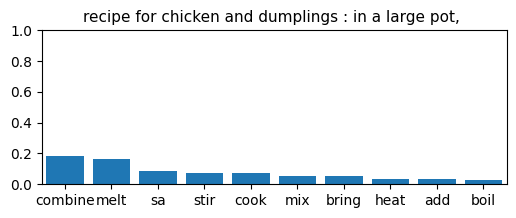

In [14]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

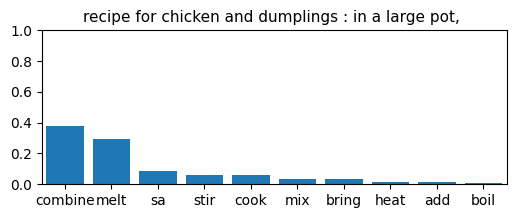

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

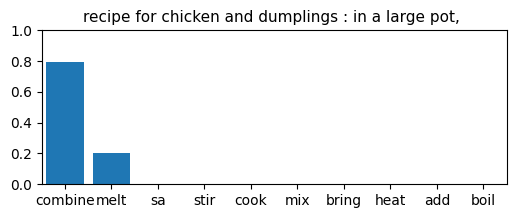

In [16]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)